
# $K^* \mu \mu$ angular analysis - Getting started

In [1]:
#importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit #minuit for minimising 
from core import load_file
from ES_functions.Compiled import selection_all

## Loading the data
Let us load the data from each bin in separate data frames, and put them in a list called `bins`.

The following assumes that the csv
file for bin i is called `toy_data_bin_i.csv` and is located in the folder `../kstarmumu_toy_data/`.

In [8]:
data_dfs = load_file('total_dataset.pkl')

selected_df, _ = selection_all(data_dfs)

# bins ordered different, because np.histogram needs a
# monotonically increasing array
q2_bins_0 = [0.1, 0.98, 1.1, 2.5, 4, 6, 8, 15, 17, 19]
q2_bins_1 = [1, 6, 11, 12.5, 15, 17.9]

selected_binned_0 = pd.cut(
    selected_df['q2'], bins=q2_bins_0,
    labels=['0', 'i1', '1', '2', '3', '4', 'i2', '5', '6']
)
selected_binned_1 = pd.cut(
    selected_df['q2'], bins=q2_bins_1,
    labels=['7', 'i3', '8', 'i4', '9']
)

selected_dfs_0 = dict(tuple(selected_df.groupby(selected_binned_0)))
selected_dfs_1 = dict(tuple(selected_df.groupby(selected_binned_1)))

bins = {**selected_dfs_0, **selected_dfs_1}

bins['0'].head()

Particle ID done


,mu_plus_MC15TuneV1_ProbNNk,mu_plus_MC15TuneV1_ProbNNpi,mu_plus_MC15TuneV1_ProbNNmu,mu_plus_MC15TuneV1_ProbNNe,mu_plus_MC15TuneV1_ProbNNp,mu_plus_P,mu_plus_PT,mu_plus_ETA,mu_plus_PHI,mu_plus_PE,...,B0_OWNPV_Y,B0_OWNPV_Z,B0_FD_OWNPV,B0_ID,q2,phi,costhetal,costhetak,polarity,year
1197,0.000904,0.374031,0.771691,3.607586e-06,2.786022e-04,12463.920000,1629.452362,2.723441,2.657955,12464.367832,...,-0.1993,7.3031,13.992146,-511,5.823036,-2.287240,-0.872194,0.427508,1,2016
2349,0.002429,0.172658,0.995551,1.090435e-05,7.954079e-03,27232.500000,4031.507869,2.597893,-1.132578,27232.704969,...,-0.1582,6.5178,8.814567,-511,1.699239,0.532158,-0.335785,0.303558,1,2016
2790,0.000131,0.051728,0.996348,4.335023e-06,1.827846e-06,41713.730000,2959.844758,3.337580,2.225899,41713.863813,...,-0.2282,-13.4851,22.430418,-511,5.287379,2.583601,0.155902,-0.970328,1,2016
2833,0.000150,0.211838,0.958714,7.324293e-09,3.686176e-06,16688.321396,1135.000850,3.380065,-2.363565,16688.655869,...,-0.1514,3.4466,7.064876,-511,2.400740,0.429923,-0.732970,-0.532755,1,2016
3191,0.000046,0.009514,0.999920,2.276337e-06,9.026443e-07,53387.300000,4673.234847,3.126947,2.945476,53387.404554,...,-0.1390,14.8640,18.114333,511,2.200452,1.285181,-0.236935,-0.935368,-1,2016


Let us have a look at the distribution of the variable $cos(\theta_l)$, which will be used below, in one of the bins.

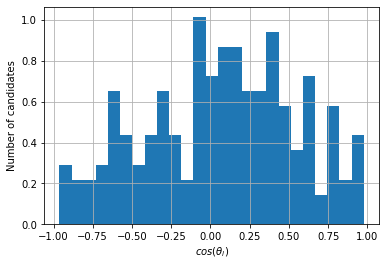

In [3]:
plt.hist(bins['3']['costhetal'], bins=25, density=True)
plt.xlabel(r'$cos(\theta_l)$')
plt.ylabel(r'Number of candidates')
plt.grid()
plt.show()

## Fitting
Let us assume a flat acceptance distribution for the following.
We have
$\frac{d^2\Gamma_P}{dq^2dcos\theta_l} = \frac{3}{8}[\frac{3}{2} - \frac{1}{2}F_L + \frac{1}{2}cos2\theta_l(1-3F_L) + \frac{8}{3}A_{FB}cos\theta_l]$

In [9]:
c_0 = np.loadtxt('acceptance_func_parameters/c_0.txt')
costhetal_0 = np.loadtxt('acceptance_func_parameters/costhetal_0.txt')
q2_normal_0 = np.loadtxt('acceptance_func_parameters/q2_normal_0.txt')

c_1 = np.loadtxt('acceptance_func_parameters/c_1.txt')
costhetal_1 = np.loadtxt('acceptance_func_parameters/costhetal_1.txt')
q2_normal_1 = np.loadtxt('acceptance_func_parameters/q2_normal_1.txt')

In [10]:
def P_0(x):
    return 1
def P_1(x):
    return x
def P_2(x):
    return 0.5*(3*x**2-1)
def P_3(x):
    return 0.5*(5*x**3-3*x)
def P_4(x):
    return 0.125*(35*x**4-30*x**2+3)
def P_5(x):
    return 0.125*(63*x**5-70*x**3+15*x)

P=[P_0,P_1,P_2,P_3,P_4,P_5]

# Continuous 2d acceptance function F(q2_normal,costhetal). Here we let q2_normal be fixed
def F (cos,q2,coe,bin_no): 
    SUM=0
    for i in range (0,6): 
        for j in range (0,6): 
            SUM+=coe[i][j]*P[i](q2[bin_no])*P[j](cos)
    return SUM

def d2gamma_p_d2q2_dcostheta(fl, afb, cos_theta_l, bin_no):
    """
    Returns the pdf defined above
    :param fl: f_l observable
    :param afb: a_fb observable
    :param cos_theta_l: cos(theta_l)
    :return:
    """
    ctl = cos_theta_l
    c2tl = 2 * ctl ** 2 - 1
    # acceptance "function" acceptance function used to correct for warping 
    # induced. This will allow for sampling with the correct weights. 
    # In general theta_l dependent.
    acceptance = F(ctl, q2_normal_1, c_1, bin_no)  
    #multiply with acceptance for correction
    scalar_array = ( 
        3/8 * (3/2 - 1/2 * fl + 1/2 * c2tl * (1 - 3 * fl) + 8/3 * afb * ctl) * acceptance
    )
    # normalising scalar array to account for the non-unity acceptance function.
    #  In general this normalisation constant will probably require integration
    normalised_scalar_array = scalar_array * 2  
    return normalised_scalar_array

def log_likelihood(fl, afb, _bin):
    """
    Returns the negative log-likelihood of the pdf defined above
    :param fl: f_l observable
    :param afb: a_fb observable
    :param _bin: number of the bin to fit
    :return:
    """
    bin_ = bins[f'{int(_bin)}']
    ctl = bin_['costhetal']
    normalised_scalar_array = d2gamma_p_d2q2_dcostheta(fl, afb, ctl, _bin)
    #summed up to find total probability for this data with the fitted parameters. 
    #negative because min easier to find than max
    return -np.sum(np.log(normalised_scalar_array)) 


In [79]:
print(c_0)
print(c_1)

[[ 3.06613260e+00  2.28480220e-02 -2.14775610e-01 -1.32509813e-03
  -3.05425893e-01  4.80938954e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.00032064e+00  1.72392606e-02  3.21104664e-01 -1.38036041e-01
   1.94713555e-01 -1.63948275e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.11112791e+00  3.33713359e-02 -3.64714670e-01  3.77671186e-02
  -4.42209220e-01  1.41397831e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.96995703e+00  8.38097265e-02  8.72074598e-03  3.81140048e-02
  -1.30318071e-01 -6.62967598e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.67031791e+00 -1.23599448e-01  1.81139957e-01 -2.78103274e-01
   2.37974309e-01 -2.68543172e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.35153407e+00  1.04610562e-01 -9.30744431e-02  5.24769625e-01
   2.35775183e-01  4.23402022e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00

Let us check how the negative log-likelihood function defined above looks like for a given bin and a fixed $A_{FB}$ or a fixed $F_L$.

C:\Users\liewz\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\liewz\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


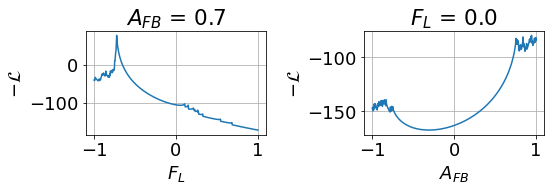

In [45]:
_test_bin = 1

#following values are used just for fixing one parameter while the other is varied
_test_afb = 0.7
_test_fl = 0.0

x = np.linspace(-1, 1, 500)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
#testing log_likelihood for different values of fl from -1 to 1
ax1.plot(x, [log_likelihood(fl=i, afb=_test_afb, _bin=_test_bin) for i in x]) 
ax1.set_title(r'$A_{FB}$ = ' + str(_test_afb))
ax1.set_xlabel(r'$F_L$')
ax1.set_ylabel(r'$-\mathcal{L}$')
ax1.grid()

#testing log_likelihood for different values of afb from -1 to 1
ax2.plot(x, [log_likelihood(fl=_test_fl, afb=i, _bin=_test_bin) for i in x]) 
ax1.set_title(r'$A_{FB}$ = ' + str(_test_afb))
ax2.set_title(r'$F_{L}$ = ' + str(_test_fl))
ax2.set_xlabel(r'$A_{FB}$')
ax2.set_ylabel(r'$-\mathcal{L}$')
ax2.grid()
plt.tight_layout()
plt.show()

Note the warning about an inalid value. For some values of the fit parameters you can get a negative PDF which leads to invalid logarithms.

### Fitting
We then use `iminuit` to optimize $A_{FB}$ and $F_L$. The function `m.migrad()` does the gradient descent minimisation of the negative log likelihood

In [13]:
import numpy as np
import numpy.linalg as la

 

def mag(v):
    m = sum(i**2 for i in v)
    return np.sqrt(m)

def LOG_likelihood(r, args):
    return log_likelihood(r[0], r[1], args)

def Newton(r,cost_func,args):
    h = 1e-6
    grad = np.zeros(len(r))
    H = h * np.array([ [ float(i == j) for i in range(len(r)) ] for j in range(len(r)) ])
    for i in range(len(r)):
        grad[i] = (cost_func(r + H[i], *args) - cost_func(r - H[i], *args) ) / (2*h)
    Hess = np.zeros(shape = (len(r), len(r)))
    for i in range(len(r)):
        for j in range(i+1):
            if i == j:
                Hess[i,i] = (cost_func(r + H[i],*args) - 2*cost_func(r,*args) + cost_func(r - H[i],*args))/h**2
            else:
                Hess[i,j] = (cost_func(r + H[i] + H[j],*args) + cost_func(r - H[i] - H[j], *args) - 
                              cost_func(r + H[i] - H[j], *args) - cost_func(r - H[i] + H[j], *args))/(4*h**2)
                Hess[j,i] = Hess[i,j]
    Hess_in = la.inv(Hess)
    r_1 = r - np.matmul(Hess_in, grad)
    try:
        if mag(r_1-r)/mag(r) < 1e-6:
            return r_1, Hess
        else:
            return Newton(r_1, cost_func, args)
    except RecursionError :
        return r_1, Hess 

for i in range(3):
    args = [i]
    init = [-0.1, 0.0]
    min_val, error = Newton(init, LOG_likelihood, args)
    
    print(f'bin={i+7}, {min_val}')

bin=7, [0.92099684 0.01486243]
bin=8, [0.34935435 0.43976072]
bin=9, [0.21686715 0.45245803]


In [47]:
#these 2 are only used for checking in the next cell
bin_number_to_check = 0  # bin that we want to check in more details in the next cell
bin_results_to_check = None


log_likelihood.errordef = Minuit.LIKELIHOOD #set to a negative log likelihood function
decimal_places = 3 #only used for outputting results
starting_point = [-0.1,0.0] #starting for fl and afb respectively

#setting up lists for outputting of results
fls, fl_errs = [], []
afbs, afb_errs = [], []

for i in range(len(bins)):
    m = Minuit(log_likelihood, fl=starting_point[0], afb=starting_point[1], _bin=i)
    # fixing the bin number as we don't want to optimize it
    m.fixed['_bin'] = True  
    #setting the limits for parameters fl, afb, and bin number in that order
    m.limits=((-1.0, 1.0), (-1.0, 1.0), None) 
    m.migrad() #find min using gradient descent
    m.hesse() #finds estimation of errors at min point by looking at th
    if i == bin_number_to_check:
        bin_results_to_check = m #sets up results for checking in the next cell
        
    fls.append(m.values[0])
    afbs.append(m.values[1])
    fl_errs.append(m.errors[0])
    afb_errs.append(m.errors[1])
    
    print(
        f"Bin {i}: {np.round(fls[i], decimal_places)} pm {np.round(fl_errs[i], decimal_places)},",
        (
            f"{np.round(afbs[i], decimal_places)} pm {np.round(afb_errs[i], decimal_places)}"
            ". Function minimum considered valid: {m.fmin.is_valid}"
        )
    )

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

It is a good idea to check the output of the minimisation. We notice again the invalid value warning so at some point in the minimisation iminuit explored an unphysical set of fit parameters. The fits all show valid function minima though so ultimately iminuit ended up somewhere reasonable. It is important to check that the fitted uncertainties are unreasonable. Very large or very small values would imply that the fit has not converged properly.

Let us also look at the profiles for $A_{FB}$ and $F_L$ for a bin (e.g. bin number 0).

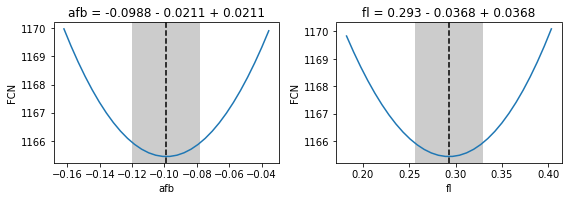

In [35]:
#drawing likelihood profiles
plt.figure(figsize=(8, 5))
plt.subplot(221)
bin_results_to_check.draw_mnprofile('afb', bound=3) 
plt.subplot(222)
bin_results_to_check.draw_mnprofile('fl', bound=3)
plt.tight_layout()
plt.show()

We can also plot the resulting fitted PDF over the measured $cos(\theta_l)$ distribution.

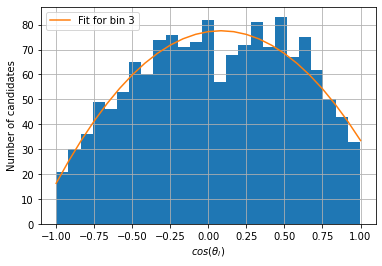

In [49]:
bin_to_plot = 3
number_of_bins_in_hist = 25

cos_theta_l_bin = bins[bin_to_plot]['ctl']
hist, _bins, _ = plt.hist(cos_theta_l_bin, bins=number_of_bins_in_hist) #plotting histogram from before

x = np.linspace(-1, 1, number_of_bins_in_hist) #range from -1 to 1
pdf_multiplier = np.sum(hist) * (np.max(cos_theta_l_bin) - np.min(cos_theta_l_bin)) / number_of_bins_in_hist #total number of results*range/number of bins; used as a multiplier so the fitted function is the right height 
y = d2gamma_p_d2q2_dcostheta(fl=fls[bin_to_plot], afb=afbs[bin_to_plot], cos_theta_l=x) * pdf_multiplier #fit using given function

plt.plot(x, y, label=f'Fit for bin {bin_to_plot}')
plt.xlabel(r'$cos(\theta_l)$')
plt.ylabel(r'Number of candidates')
plt.legend()
plt.grid()
plt.show()

Finally, let us visualize the results in each bin.

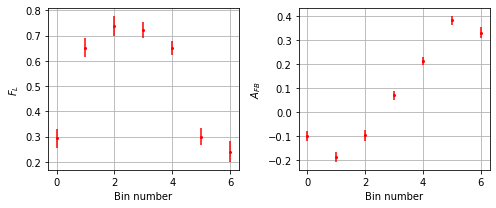

In [9]:
#plotting the results values of fl and afb from each bin with their corresponding erros
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.errorbar(np.linspace(0, len(bins) - 1, len(bins)), fls, yerr=fl_errs, fmt='o', markersize=2, label=r'$F_L$', color='red')
ax2.errorbar(np.linspace(0, len(bins) - 1, len(bins)), afbs, yerr=afb_errs, fmt='o', markersize=2, label=r'$A_{FB}$', color='red')
ax1.grid()
ax2.grid()
ax1.set_ylabel(r'$F_L$')
ax2.set_ylabel(r'$A_{FB}$')
ax1.set_xlabel(r'Bin number')
ax2.set_xlabel(r'Bin number')
plt.tight_layout()
plt.show()
